In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import FactorAnalysis

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data1 = pd.read_csv(r"datasets\imputed_data_QS_RF.csv")
data2 = pd.read_csv(r"datasets\imputed_data_QS_XGB.csv")
data2_sub = data2[['Institution Name', 'Year', 'IRN_SCORE', 'EO_SCORE', 'S_SCORE']]
# 进行合并
merged_df = pd.merge(data1, data2_sub, on=['Institution Name', 'Year'], how='left')
# 计算平均值并创建新列
merged_df['IRN_SCORE'] = (merged_df['IRN_SCORE_x'] + merged_df['IRN_SCORE_y']) / 2
merged_df['EO_SCORE']  = (merged_df['EO_SCORE_x']  + merged_df['EO_SCORE_y'])  / 2
merged_df['S_SCORE']   = (merged_df['S_SCORE_x']   + merged_df['S_SCORE_y'])   / 2
merged_df.drop(columns=['IRN_SCORE_x', 'IRN_SCORE_y',
                        'EO_SCORE_x',  'EO_SCORE_y',
                        'S_SCORE_x',   'S_SCORE_y'], inplace=True)
data = merged_df
numeric_data = data.drop(columns=['Rank', 'Institution Name', 'Country', 'Year','CS','CF','RI','Age','STA','Overall'])
numeric_data_standardized = (numeric_data - numeric_data.mean()) / numeric_data.std()
 

In [3]:
numeric_data_standardized.head()

,AR_SCORE,ER_SCORE,FS_SCORE,CPF_SCORE,IF_SCORE,IS_SCORE,IRN_SCORE,EO_SCORE,S_SCORE
0,2.860526,2.722843,2.177381,2.302591,1.800375,1.988527,1.232425,2.918425,1.913042
1,2.860526,2.722843,2.177381,2.285786,1.789078,1.256705,1.574039,2.961351,1.930189
2,2.860526,2.722843,2.120115,2.302591,1.701525,1.334891,1.549857,2.940762,1.956016
3,2.840967,2.177224,2.177381,2.305952,1.613973,1.772733,0.580724,1.317907,1.042702
4,2.860526,2.722843,2.177381,1.576632,1.726944,2.038566,1.583625,2.950500,1.603607


In [4]:
file_patht = r"datasets/cleaned_data_THE.csv"
dft = pd.read_csv(file_patht, encoding='latin1')

### Implementing PCA

In [5]:
pca = PCA()
pca.fit(numeric_data_standardized)

explained_variance_ratio = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_

for i, var in enumerate(explained_variance_ratio, start=1):
    print(f"PC{i}: {var * 100:.2f}% variance explained")

PC1: 54.87% variance explained
PC2: 12.78% variance explained
PC3: 10.68% variance explained
PC4: 7.05% variance explained
PC5: 5.40% variance explained
PC6: 3.47% variance explained
PC7: 2.45% variance explained
PC8: 2.01% variance explained
PC9: 1.29% variance explained


### Factor Analysis

In [6]:
# KMO Test
scaler = StandardScaler()
df_scaled = scaler.fit_transform(numeric_data)

kmo_all,kmo_model=calculate_kmo(df_scaled)
kmo_model

0.8635006378525298

In [7]:
# Bartlett’s Test of Sphericity
chi2_val, p_val = calculate_bartlett_sphericity(numeric_data)

print(f"Bartlett's test of result:")
print(f"statistic = {chi2_val:.4f}")
print(p_val,"p-value")

Bartlett's test of result:
statistic = 53916.6097
0.0 p-value


In [8]:
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer()
fa.fit(numeric_data_standardized)
eigen_values, vectors = fa.get_eigenvalues()
eigen_values

array([4.93801103, 1.15023983, 0.96134098, 0.63418855, 0.4861908 ,
       0.31221208, 0.22067411, 0.18088062, 0.116262  ])

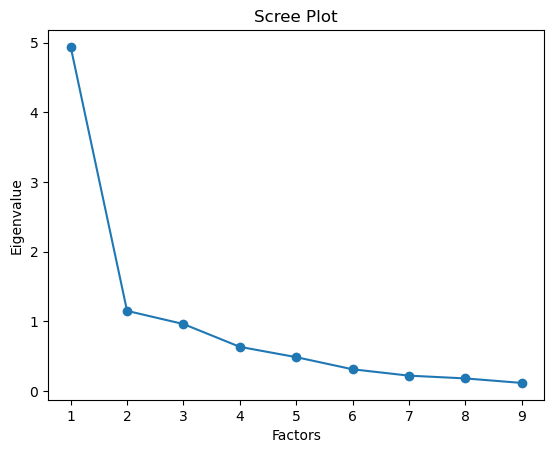

In [9]:
plt.scatter(range(1,df_scaled.shape[1]+1),eigen_values)
plt.plot(range(1,df_scaled.shape[1]+1),eigen_values)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.show()

In [10]:
fa = FactorAnalyzer(n_factors=4, rotation='varimax', method='principal')
fa.fit(numeric_data_standardized)

fa1 = FactorAnalyzer(n_factors=4, rotation=None, method='principal')
fa1.fit(numeric_data_standardized)

loadings = pd.DataFrame(
    fa.loadings_,
    index = numeric_data_standardized.columns,
    columns=['Factor1', 'Factor2','Factor3','Factor4']
)
print("Loading matrix：\n", loadings)

Loading matrix：
             Factor1   Factor2   Factor3   Factor4
AR_SCORE   0.830400  0.154973  0.159562  0.407844
ER_SCORE   0.891636  0.181939  0.125742  0.187283
FS_SCORE   0.200306  0.093759  0.973899  0.043045
CPF_SCORE  0.165706  0.202467  0.008022  0.829739
IF_SCORE   0.162691  0.855887  0.039112  0.278967
IS_SCORE   0.205551  0.883467  0.095141  0.152444
IRN_SCORE  0.396751  0.187136  0.049063  0.774420
EO_SCORE   0.858643  0.180056  0.119575  0.252046
S_SCORE    0.537244  0.298661  0.097417  0.648350


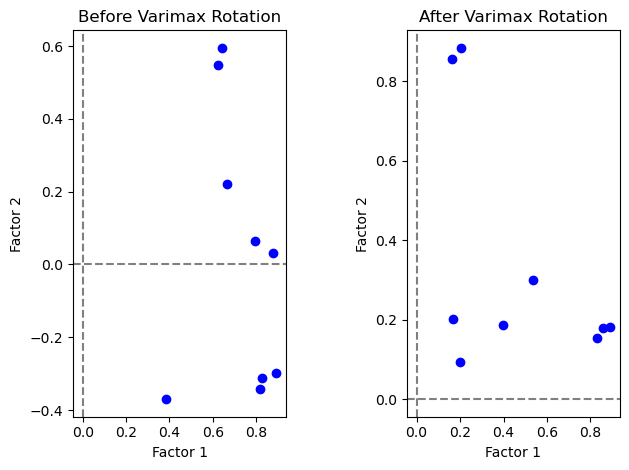

In [11]:
# Plot the difference of using rotation
plt.subplot(1, 2, 1)
plt.scatter(fa1.loadings_[:, 0], fa1.loadings_[:, 1], c='blue')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.title("Before Varimax Rotation")
plt.xlabel("Factor 1")
plt.ylabel("Factor 2")

plt.subplot(1, 2, 2)
plt.scatter(fa.loadings_[:, 0], fa.loadings_[:, 1], c='blue')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.title("After Varimax Rotation")
plt.xlabel("Factor 1")
plt.ylabel("Factor 2")

plt.tight_layout(w_pad=5.0, h_pad=2.0)
plt.show()

Factor 1: 1,2,8  AR_SCORE, ER_SCORE, EO_SCORE

Factor 2: 5,6  IF_SCORE, IS_SCORE

Factor 3: 3  FS_SCORE

Factor 4: 4,7,9  CPF_SCORE, IRN_SCORE , S_SCORE

In [12]:
cum_explained_variance_ratio = fa.get_factor_variance()
for i, var in enumerate(cum_explained_variance_ratio[2], start=1):
    print(f"Factor{i}: {var * 100:.2f}% culmulative variance explained")

Factor1: 31.16% culmulative variance explained
Factor2: 50.90% culmulative variance explained
Factor3: 62.30% culmulative variance explained
Factor4: 85.38% culmulative variance explained


In [13]:
fa.get_communalities()

array([0.90537734, 0.8790024 , 0.99924572, 0.75698226, 0.8383639 ,
       0.85505594, 0.79456425, 0.84751226, 0.80767629])

### Calculate FA_Score

In [21]:
FA_Score = fa.fit_transform(numeric_data_standardized)
FA_Score = pd.DataFrame(FA_Score, columns=['FA_1', 'FA_2','FA_3','FA_4'])
FA_Score_standardized = (FA_Score - FA_Score.min()) / (FA_Score.max() - FA_Score.min())
FA_Score_standardized

,FA_1,FA_2,FA_3,FA_4
0,0.750823,0.656702,0.761646,0.662480
1,0.754606,0.546295,0.764563,0.717952
2,0.755414,0.546932,0.751354,0.717664
3,0.604528,0.641283,0.817483,0.649147
4,0.779941,0.662119,0.757020,0.590281
...,...,...,...,...
8962,0.314140,0.303999,0.225657,0.439342
8963,0.290791,0.362183,0.402158,0.323735
8964,0.294171,0.244545,0.244993,0.474353
8965,0.257573,0.237950,0.537399,0.404727


### Calculate PCA_Score

In [15]:
col_factor1 = ['AR_SCORE', 'ER_SCORE', 'EO_SCORE']
col_factor2 = ['IF_SCORE', 'IS_SCORE']
col_factor3 = ['FS_SCORE']
col_factor4 = ['CPF_SCORE', 'IRN_SCORE', 'S_SCORE']
factor1 = numeric_data_standardized[col_factor1]
factor2 = numeric_data_standardized[col_factor2]
factor3 = numeric_data_standardized[col_factor3]
factor4 = numeric_data_standardized[col_factor4]

In [16]:
# PCA for each factor
factor_num = loadings.shape[1]
explained_variance_ratio = np.zeros(factor_num)

pca = PCA(n_components = 1)
pca_scores1 = pca.fit_transform(factor1)
explained_variance_ratio[0] = pca.explained_variance_ratio_[0]
pca_scores2 = pca.fit_transform(factor2)
explained_variance_ratio[1] = pca.explained_variance_ratio_[0]
pca_scores3 = pca.fit_transform(factor3)
explained_variance_ratio[2] = pca.explained_variance_ratio_[0]
pca_scores4 = pca.fit_transform(factor4)
explained_variance_ratio[3] = pca.explained_variance_ratio_[0]

In [17]:
for i, var in enumerate(explained_variance_ratio, start=1):
    print(f"Factor {i}: {var * 100:.2f}% variance explained")

Factor 1: 87.57% variance explained
Factor 2: 84.21% variance explained
Factor 3: 100.00% variance explained
Factor 4: 76.16% variance explained


In [18]:
PCA_Score = np.column_stack((pca_scores1, pca_scores2, pca_scores3, pca_scores4))
PCA_Score = pd.DataFrame(PCA_Score, columns=['pca_1', 'pca_2','pca_3','pca_4'])
PCA_Score_standardized = (PCA_Score - PCA_Score.min()) / (PCA_Score.max() - PCA_Score.min())
PCA_Score_standardized.head()

,pca_1,pca_2,pca_3,pca_4
0,0.994327,0.979290,1.000000,0.938517
1,0.997998,0.853110,1.000000,0.974591
2,0.996237,0.851520,0.982811,0.976295
3,0.808357,0.910998,1.000000,0.779370
4,0.997070,0.975318,1.000000,0.876633


In [20]:
model_score = pd.concat([data[['Institution Name','Country','Year']],FA_Score_standardized, PCA_Score_standardized],axis = 1)
model_score.to_csv('datasets\model_score_qs.csv',index = False)
model_score.head()

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
C:\Users\zxy\AppData\Local\Temp\ipykernel_19112\3245975041.py:2: SyntaxWarning: invalid escape sequence '\m'
  model_score.to_csv('datasets\model_score_qs.csv',index = False)


,Institution Name,Country,Year,FA_1,FA_2,FA_3,FA_4,pca_1,pca_2,pca_3,pca_4
0,MASSACHUSETTS INSTITUTE OF TECHNOLOGY (MIT),United States,2018,0.750823,0.656702,0.761646,0.662480,0.994327,0.979290,1.000000,0.938517
1,STANFORD UNIVERSITY,United States,2018,0.754606,0.546295,0.764563,0.717952,0.997998,0.853110,1.000000,0.974591
2,HARVARD UNIVERSITY,United States,2018,0.755414,0.546932,0.751354,0.717664,0.996237,0.851520,0.982811,0.976295
3,CALIFORNIA INSTITUTE OF TECHNOLOGY (CALTECH),United States,2018,0.604528,0.641283,0.817483,0.649147,0.808357,0.910998,1.000000,0.779370
4,UNIVERSITY OF CAMBRIDGE,United Kingdom,2018,0.779941,0.662119,0.757020,0.590281,0.997070,0.975318,1.000000,0.876633
